         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


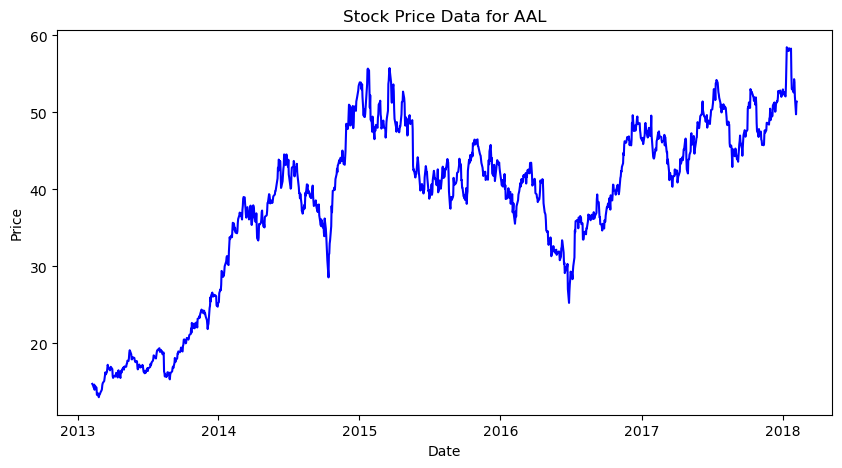

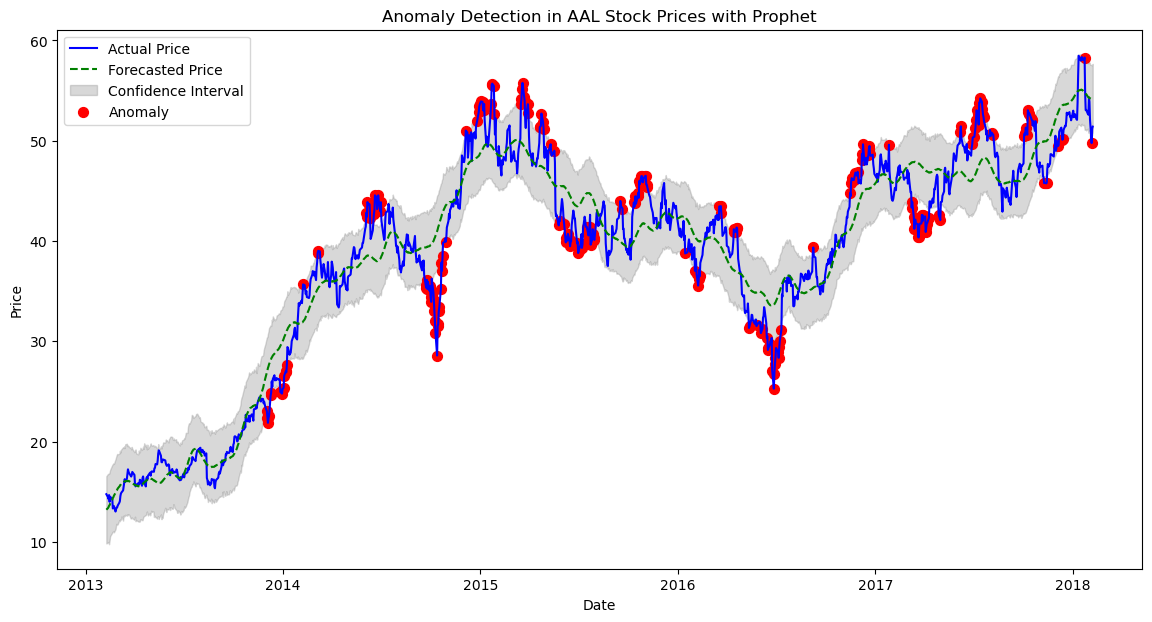

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Load the dataset
df = pd.read_csv('all_stocks_5yr.csv')  # loading the dataset

# Display column names and first few rows to verify structure
print(df.head())

# Step 1: Filter the Data for a Single Stock (e.g., 'AAL')
stock_name = 'AAL'  # Change this to the desired stock symbol
df = df[df['Name'] == stock_name]

# Rename columns to fit Prophet's requirements
df['date'] = pd.to_datetime(df['date'])  # Adjust 'date' if the column is named differently
df.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)  # Adjust 'close' if using a different price column

# Plot the filtered data to understand the structure
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], color='blue')
plt.title(f'Stock Price Data for {stock_name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Step 2: Initialize and Fit the Prophet Model
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(df)

# Step 3: Forecast Future Data
# Generate future dates for forecast (we'll limit this to existing data only)
future = prophet_model.make_future_dataframe(periods=0, freq='D')
forecast = prophet_model.predict(future)

# Step 4: Anomaly Detection by Comparing Actual and Forecasted Data
# Merge the forecasted data back with the original to compare
df = df.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
df.rename(columns={'yhat': 'forecast', 'yhat_lower': 'forecast_lower', 'yhat_upper': 'forecast_upper'}, inplace=True)

# Mark anomalies where actual values are outside the forecasted confidence interval
df['anomaly'] = 0
df.loc[(df['y'] < df['forecast_lower']) | (df['y'] > df['forecast_upper']), 'anomaly'] = 1

# Ensure no missing values in forecasted columns for plotting
df['forecast'] = df['forecast'].ffill()
df['forecast_lower'] = df['forecast_lower'].ffill()
df['forecast_upper'] = df['forecast_upper'].ffill()

# Visualize Stock Price Data and Detected Anomalies
plt.figure(figsize=(14, 7))
plt.plot(df['ds'], df['y'], color='blue', label='Actual Price')
plt.plot(df['ds'], df['forecast'], color='green', linestyle='--', label='Forecasted Price')
plt.fill_between(df['ds'], df['forecast_lower'], df['forecast_upper'], color='gray', alpha=0.3, label='Confidence Interval')

# Highlight anomalies
anomalies = df[df['anomaly'] == 1]
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomaly', s=50)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Anomaly Detection in {stock_name} Stock Prices with Prophet')
plt.legend()
plt.show()
